### Imports

In [63]:
import pandas as pd
import numpy as np
import sklearn as skit
import math

import geopy
from geopy.distance import VincentyDistance

from scipy import constants
constants.value



<function scipy.constants.codata.value(key)>

###    Funcao  PATH   

In [64]:

#calcula  distancia entre dois pontos B e M
def dist_BS_MS(latB, lonB, latM,lonM):
    coord_base = (latB, lonB)
    coord_mobi = (latM, lonM)
    return geopy.distance.vincenty(coord_base, coord_mobi).m


#calculo do Path loss para dada distancia
def freeSpacePL(dist, freq):
    return 32.44 + 20*np.log10(dist) + 20*np.log10(freq)
    
    # dei uma comentado pra usar da forma que está no git de robson, parecia estar certo, mas esse 147.55 eu não calculei
    # sei que é o resultado lá dos ganhos mas... depois debate isso
    
    #return 20*math.log(dist,10) + 20*math.log(freq,10) + 147.55221
    
    #conferir corretude em: https://www.everythingrf.com/rf-calculators/free-space-path-loss-calculator
#print(_FSPL(2, 1800000000))

def leeModelPL(dist, freq):
    n0 = 3.84
    p0 = 61.7
    txH = 50.0
    rxH = 1.5
    nf = 3 if freq > 850 else 2
    X2 = 2 if rxH > 3 else 1
    L1 = -20*np.log10(txH/30)
    L2 = -10*X2*np.log10(rxH/3)
    Lo = 50.3 + p0 - 10*n0*np.log10(1.61)-10*nf*np.log10(900)
    L = Lo + 10*n0*np.log10(dist)+10*nf*np.log10(freq)+L1+L2
    return L

def flatEarthPL(dist, freq):
    return 120 + (40*np.log10(dist)) - (20*np.log10(50.0) - (20*np.log10(1.5)))

                                  

In [65]:
#names=["pontoId","lat","lon","pathBTS1","pathBTS2","pathBTS3","pathBTS4","pathBTS5","pathBTS6","taBTS1","taBTS2","taBTS3","taBTS4","taBTS5","taBTS6"]
#BD referencia
df_ref = pd.read_csv("LocTreino_Equipe_6.csv")
df_ref_robson = pd.read_csv("LocTest.csv")

#ler df de robson e passar para df_ref2
df_ref2 = df_ref_robson

df_ref = df_ref.drop(['pontoId','taBTS1','taBTS2','taBTS3','taBTS4','taBTS5','taBTS6'], axis = 1)

df_ref.head()



,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6
0,-8.076391,-34.895985,120.610000,104.380000,129.970000,123.620000,129.460000,132.080000
1,-8.072939,-34.895676,105.290000,121.523333,106.556667,108.756667,122.556667,126.123333
2,-8.076256,-34.899773,122.256667,110.423333,124.490000,135.256667,142.956667,142.556667
3,-8.064446,-34.889416,127.423333,132.656667,130.556667,131.856667,126.090000,137.723333
4,-8.068819,-34.888874,121.490000,136.423333,128.190000,122.723333,107.256667,120.323333


In [66]:
#Antenas
df_antenas = pd.read_csv("dados_BTSs.csv")
df_antenas


,name,lat,lon,band,bcch,eirp,bts
0,136_2,-8.068361,-34.892722,GSM1800,662,55.59,BTS-1
1,137_3,-8.075917,-34.894611,GSM1800,806,55.59,BTS-2
2,197_1,-8.076361,-34.908000,GSM1800,666,55.59,BTS-3
3,137_1,-8.075917,-34.894611,GSM1800,690,55.59,BTS-4
4,138_2,-8.066000,-34.889444,GSM1800,673,55.59,BTS-5
5,245_2,-8.064583,-34.894583,GSM1800,682,55.59,BTS-6


### lat's e lon's das extermidade do mapa
### largura e altura do grid

In [67]:
min_lat = df_ref['lat'].min()
max_lat = df_ref['lat'].max()
min_lon = df_ref['lon'].min()
max_lon = df_ref['lon'].max()

print("latitude maxima: {}".format(max_lat))
print("latitude minima: {}".format(min_lat))
print("***")
print("long maxima: {}".format(max_lon))
print("long minima: {}".format(min_lon))
print("***")
#coord -> (lat lon)
coord_min_min = (min_lat, min_lon)
coord_min_max = (min_lat, max_lon)
coord_max_max = (max_lat, max_lon)
coord_max_min = (max_lat, min_lon)

#rtg -> retangulo

grid_wd = math.ceil(geopy.distance.vincenty(coord_min_min, coord_min_max).m)
grid_ht = math.ceil(geopy.distance.vincenty(coord_min_min, coord_max_min).m)
print ("largura do grid em metros: {}".format(grid_wd))
print ("altura do grid em metros: {}".format(grid_ht))

latitude maxima: -8.059338
latitude minima: -8.077575999999999
***
long maxima: -34.885067
long minima: -34.90683
***
largura do grid em metros: 2399
altura do grid em metros: 2018


### altura, largura e quantidade de celulas
#cell_wd = prop x cell_ht
#cell_wd -> 100 metros

In [68]:
prop = grid_wd/grid_ht
#print(prop)
cell_ht = 50 #em metros
cell_wd = math.ceil(prop*cell_ht)

print("celula tem {} metros de largura".format(cell_wd +1))
print("celula tem {} metros de altura".format(cell_ht))

math.ceil
num_col = math.ceil(grid_wd/cell_wd)
num_row = math.ceil(grid_ht/cell_ht)
n_of_cells = int(num_col*num_row)

print("total de linhas: {}".format(num_row))
print("total de colunas: {}".format(num_col))

print("total de celulas: {}".format(n_of_cells))


celula tem 61 metros de largura
celula tem 50 metros de altura
total de linhas: 41
total de colunas: 40
total de celulas: 1640


### lat's e lon's de todos as celulas do grid

In [69]:

# calculo as coord do centro da primeira celula (mais abaixo e mais a esquerda):
origem = geopy.Point(min_lat, min_lon)
angulo = math.degrees(math.atan(cell_ht/cell_wd))
hipotenusa = math.hypot(cell_ht/2,cell_wd/2)
destination = VincentyDistance(meters=hipotenusa).destination(origem, angulo)
lat0, lon0 = destination.latitude, destination.longitude

#com base em lat0 e lon0 gerar as lats e as lons para as demais celulas:
latx,  lonx = lat0, lon0 
lats, lons = [], []
for l in range(num_row):
    for c in range(num_col):
        #add a lista
        lats.append(latx)
        lons.append(lonx)
        #proximas celulas a direita
        origem = geopy.Point(latx, lonx)
        destination = VincentyDistance(meters=cell_wd).destination(origem, math.degrees(0))
        latx, lonx = destination.latitude, destination.longitude
    #vai para a celula mais a esqueda da linha de cima
    origem = geopy.Point(lat0, lon0)
    destination = VincentyDistance(meters=(l+1)*cell_wd).destination(origem, math.degrees(math.pi/2))
    latx, lonx = destination.latitude, destination.longitude
print(len(lats))
    
data = np.array([lats, lons])
df_cells_coord = pd.DataFrame({'lat':data[0], 'lon':data[1]})
df_cells_coord.head()


1640


,lat,lon
0,-8.077305,-34.906603
1,-8.076762,-34.906603
2,-8.076220,-34.906603
3,-8.075677,-34.906603
4,-8.075135,-34.906603


### Calculo do path de todos as celulas

In [70]:
#def dist_BS_MS(latB, lonB, latM,lonM):
#def _FSPL(dist, freq):

#print (dist_BS_MS(min_lat, min_lon, min_lat, max_lon))
df_antenas.head()

path_loss_BS1 = []
path_loss_BS2 = []
path_loss_BS3 = []
path_loss_BS4 = []
path_loss_BS5 = []
path_loss_BS6 = []

print(len(df_cells_coord))
print(len(path_loss_BS1))
print(len(df_antenas))

n_cells = len(df_cells_coord)


#BS_1
for j in range(n_cells):
    dist = dist_BS_MS(df_antenas.lat[0], df_antenas.lon[0], df_cells_coord.lat[j], df_cells_coord.lon[j])
    #pl1 = freeSpacePL(dist, 1800*(10**6))
    #pl1 = leeModelPL(dist, 1800*(10**6))
    pl1 = flatEarthPL(dist, 1800*(10**6))
    path_loss_BS1.append(pl1)
    #pl2 = leeModelPL(dist, 1800*(10**6))
    #path_loss_BS1[1].append(pl2)
    #pl3 = flatEarthPL(dist, 1800*(10**6))
    #path_loss_BS1[2].append(pl3)
    
    
print(len(path_loss_BS1))

#BS_2
for j in range(n_cells):
    dist = dist_BS_MS(df_antenas.lat[1], df_antenas.lon[1], df_cells_coord.lat[j], df_cells_coord.lon[j])
    pl1 = freeSpacePL(dist, 1800*(10**6))
    #pl1 = leeModelPL(dist, 1800*(10**6))
    #pl1 = flatEarthPL(dist, 1800*(10**6))
    path_loss_BS2.append(pl1)
    #pl2 = leeModelPL(dist, 1800*(10**6))
    #path_loss_BS2.append(pl2)
    #pl3 = flatEarthPL(dist, 1800*(10**6))
    #path_loss_BS2.append(pl3)
print(len(path_loss_BS2))

#BS_3
for j in range(n_cells):
    dist = dist_BS_MS(df_antenas.lat[2], df_antenas.lon[2], df_cells_coord.lat[j], df_cells_coord.lon[j])
    pl1 = freeSpacePL(dist, 1800*(10**6))
    #pl1 = leeModelPL(dist, 1800*(10**6))
    #pl1 = flatEarthPL(dist, 1800*(10**6))
    path_loss_BS3.append(pl1)
    #pl2 = leeModelPL(dist, 1800*(10**6))
    #path_loss_BS3.append(pl2)
    #pl3 = flatEarthPL(dist, 1800*(10**6))
    #path_loss_BS3.append(pl3)
print(len(path_loss_BS3))

#BS_4
for j in range(n_cells):
    dist = dist_BS_MS(df_antenas.lat[3], df_antenas.lon[3], df_cells_coord.lat[j], df_cells_coord.lon[j])
    pl1 = freeSpacePL(dist, 1800*(10**6))
    #pl1 = leeModelPL(dist, 1800*(10**6))
    #pl1 = flatEarthPL(dist, 1800*(10**6))
    path_loss_BS4.append(pl1)
    #pl2 = leeModelPL(dist, 1800*(10**6))
    #path_loss_BS4.append(pl2)
    #pl3 = flatEarthPL(dist, 1800*(10**6))
    #path_loss_BS4.append(pl3)
print(len(path_loss_BS4))

#BS_5
for j in range(n_cells):
    dist = dist_BS_MS(df_antenas.lat[4], df_antenas.lon[4], df_cells_coord.lat[j], df_cells_coord.lon[j])
    pl1 = freeSpacePL(dist, 1800*(10**6))
    #pl1 = leeModelPL(dist, 1800*(10**6))
    #pl1 = flatEarthPL(dist, 1800*(10**6))
    path_loss_BS5.append(pl1)
    #pl2 = leeModelPL(dist, 1800*(10**6))
    #path_loss_BS5.append(pl2)
    #pl3 = flatEarthPL(dist, 1800*(10**6))
    #path_loss_BS5.append(pl3)
print(len(path_loss_BS5))

    
#BS_6
for j in range(n_cells):
    dist = dist_BS_MS(df_antenas.lat[5], df_antenas.lon[5], df_cells_coord.lat[j], df_cells_coord.lon[j])
    pl1 = freeSpacePL(dist, 1800*(10**6))
    #pl1 = leeModelPL(dist, 1800*(10**6))
    #pl1 = flatEarthPL(dist, 1800*(10**6))
    path_loss_BS6.append(pl1)
    #pl2 = leeModelPL(dist, 1800*(10**6))
    #path_loss_BS6.append(pl2)
    #pl3 = flatEarthPL(dist, 1800*(10**6))
    #path_loss_BS6.append(pl3)
print(len(path_loss_BS6))

print('fim')


1640
0
6
1640
1640
1640
1640
1640
1640
fim


### Data frame com path dos centros das celulas

In [71]:
data_path = np.array([path_loss_BS1, path_loss_BS2, path_loss_BS3, path_loss_BS4, path_loss_BS5, path_loss_BS6])

data_path
df_cells_path = pd.DataFrame({'pathBTS1':data_path[0], 'pathBTS2':data_path[1], 'pathBTS3':data_path[2], 'pathBTS4':data_path[3], 'pathBTS5':data_path[4], 'pathBTS6':data_path[5]})
df_cells_path.head()



,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6
0,219.963387,280.026940,262.935615,280.026940,284.655238,283.268099
1,219.656871,279.990440,261.640019,279.990439,284.529725,283.071583
2,219.359361,279.971553,261.338217,279.971552,284.406924,282.874927
3,219.072201,279.970510,262.232614,279.970510,284.287175,282.678543
4,218.796797,279.987325,263.788433,279.987325,284.170836,282.482899


### Dataframe com coord e path dos centros das celulas

In [72]:
df_cell_coords_paths = df_cells_coord.join(df_cells_path, lsuffix='_df_cells_coord', rsuffix='_df_cells_path')

print(len(df_cell_coords_paths))

df_cell_coords_paths.head()

1640


,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6
0,-8.077305,-34.906603,219.963387,280.026940,262.935615,280.026940,284.655238,283.268099
1,-8.076762,-34.906603,219.656871,279.990440,261.640019,279.990439,284.529725,283.071583
2,-8.076220,-34.906603,219.359361,279.971553,261.338217,279.971552,284.406924,282.874927
3,-8.075677,-34.906603,219.072201,279.970510,262.232614,279.970510,284.287175,282.678543
4,-8.075135,-34.906603,218.796797,279.987325,263.788433,279.987325,284.170836,282.482899


In [73]:
df_cell_coords_paths['pathBTS1'].min()

154.38743349128572

### K-fold cross validation

In [74]:
features = ['pathBTS1', 'pathBTS2', 'pathBTS3', 'pathBTS4', 'pathBTS5', 'pathBTS6']
to_predict=['lat', 'lon']

### GRID com KNN

In [75]:
df = df_ref.iloc[:, 0:9]
df = df.dropna(axis='rows')
df.head()

,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6
0,-8.076391,-34.895985,120.610000,104.380000,129.970000,123.620000,129.460000,132.080000
1,-8.072939,-34.895676,105.290000,121.523333,106.556667,108.756667,122.556667,126.123333
2,-8.076256,-34.899773,122.256667,110.423333,124.490000,135.256667,142.956667,142.556667
3,-8.064446,-34.889416,127.423333,132.656667,130.556667,131.856667,126.090000,137.723333
4,-8.068819,-34.888874,121.490000,136.423333,128.190000,122.723333,107.256667,120.323333


In [76]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor

def knn_grid(celula, medicao):
    
    X = medicao.iloc[:, 0:2]
    y = medicao.iloc[:, 2:]
    
    pos = list(zip(medicao.iloc[:, 0], medicao.iloc[:, 1]))
    
    knn = KNeighborsRegressor(n_neighbors=5)
    multi = MultiOutputRegressor(knn).fit(X, y)
    
    linhas = []
    
    for i in range(len(celula)):
        
        linha = {'lat':'', 'lon':'', 'pathBTS1':'', 'pathBTS2':'', 'pathBTS3':'', 'pathBTS4':'', 'pathBTS5':'', 'pathBTS6':''}
        posAtual = [[celula.iloc[i, 0], celula.iloc[i, 1]]]
        y_pred = multi.predict(posAtual)
        
        linha['lat'] = celula.iloc[i,0]
        linha['lon'] = celula.iloc[i,1]
        linha['pathBTS1'] = y_pred[0,0]
        linha['pathBTS2'] = y_pred[0,1]
        linha['pathBTS3'] = y_pred[0,2]
        linha['pathBTS4'] = y_pred[0,3]
        linha['pathBTS5'] = y_pred[0,4]
        linha['pathBTS6'] = y_pred[0,5]
        
        linhas.append(linha)
        
    df = pd.DataFrame(linhas)
    return df


In [77]:
df = df_ref.iloc[:, 0:9]
df = df.dropna(axis='rows')
grid = knn_grid(df_cells_coord,df)
grid.head()

,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6
0,-8.077305,-34.906603,123.873333,116.983333,124.086667,132.093333,139.893333,137.573333
1,-8.076762,-34.906603,121.806667,119.230000,118.320000,130.523333,140.266667,137.443333
2,-8.076220,-34.906603,120.716667,117.626667,112.106667,126.840000,139.066667,135.403333
3,-8.075677,-34.906603,124.410000,116.226667,117.126667,125.096667,142.456667,138.776667
4,-8.075135,-34.906603,123.448333,120.756667,120.860000,126.446667,143.538333,137.108333


In [78]:
df.head()

,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6
0,-8.076391,-34.895985,120.610000,104.380000,129.970000,123.620000,129.460000,132.080000
1,-8.072939,-34.895676,105.290000,121.523333,106.556667,108.756667,122.556667,126.123333
2,-8.076256,-34.899773,122.256667,110.423333,124.490000,135.256667,142.956667,142.556667
3,-8.064446,-34.889416,127.423333,132.656667,130.556667,131.856667,126.090000,137.723333
4,-8.068819,-34.888874,121.490000,136.423333,128.190000,122.723333,107.256667,120.323333


### Seleção células de interesse


In [79]:
len(grid)

1640

In [80]:
len(df)

1498

In [81]:
df_total = pd.concat([df,grid])
df_total.head()

,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6
0,-8.076391,-34.895985,120.610000,104.380000,129.970000,123.620000,129.460000,132.080000
1,-8.072939,-34.895676,105.290000,121.523333,106.556667,108.756667,122.556667,126.123333
2,-8.076256,-34.899773,122.256667,110.423333,124.490000,135.256667,142.956667,142.556667
3,-8.064446,-34.889416,127.423333,132.656667,130.556667,131.856667,126.090000,137.723333
4,-8.068819,-34.888874,121.490000,136.423333,128.190000,122.723333,107.256667,120.323333


In [82]:
len(df_total)

3138

In [83]:
df_total.to_csv('df_total.csv', sep='\t')

In [84]:

import math

def divideCell(lat, lon):
    pi = math.pi
    half_width = 61/2
    half_length = 50/2
    r_earth = 6378*1000
    
    new_latitude_mais  = lat  + (half_length / r_earth) * (180 / pi);
    new_longitude_mais = lon + (half_width / r_earth) * (180 / pi) / math.cos(lat * pi/180);
    new_latitude_menos  = lat  + ((-half_length) / r_earth) * (180 / pi);
    new_longitude_menos = lon + ((-half_width) / r_earth) * (180 / pi) / math.cos(lat * pi/180);
    
    # (+lat +lon), (+lat -lon), (-lat +lon), (-lat -lon)
    return [(new_latitude_mais, new_longitude_mais), (new_latitude_mais, new_longitude_menos),
            (new_latitude_menos, new_longitude_mais), (new_latitude_menos, new_longitude_menos)]

#new_cells = divideCell(-8.077305, -34.906603)
#print(new_cells)

In [85]:
def addNewCellsToGrid(gridEx): 
    count = 0
    new_rows = []
    aux_rows = []
    rows_to_drop = []

    # PARÂMETROS DA CONDIÇÃO ENCONTRADOS COM O USO DO VIKAMINE ( LINK PARA DOWNLOAD -> https://bit.ly/2TUkyew )
    # DADOS USADOS PARA O VIKAMINE: df_total.csv
    for index, row in gridEx.iterrows():
        if(((float(row['pathBTS1']) > 132.17) and (float(row['pathBTS4']) > 130.838) and (float(row['pathBTS3']) > 132.118))or 
           ((float(row['pathBTS2']) > 130.052) and (float(row['pathBTS5']) < 114.867) and (float(row['pathBTS6']) > 137.78))):
            
            # index das rows que vão ser dropadas antes do retorno pois foram divididas
            rows_to_drop.append(index)
            
            count = count +1
            new_cells = divideCell(row['lat'], row['lon'])
            
            each_cell = {'lat':'', 'lon':'', 'pathBTS1':'', 'pathBTS2':'', 'pathBTS3':'', 'pathBTS4':'', 'pathBTS5':'', 'pathBTS6':''}
            cell_latLon = {'lat':'', 'lon':''} 
            
            for cell in new_cells:
                each_cell['lat'] = cell[0]
                each_cell['lon'] = cell[1]
                new_rows.append(each_cell)
                cell_latLon['lat'] = cell[0]
                cell_latLon['lon'] = cell[1]
                aux_rows.append(cell_latLon)
    
    # adiciona novas rows ao grid
    
    df_novo_grid = gridEx.drop(rows_to_drop, axis=0) # dropping rows que foram divididas
    df_cells = pd.DataFrame(aux_rows)
    
    # 
    df_novo_cells = knn_grid(df_cells, grid)
    df_novo_grid = pd.concat([df_novo_grid, df_novo_cells], axis=0)

    return df_novo_grid, df_cells

In [86]:
df_novo_grid, df_cells = addNewCellsToGrid(grid)
df_novo_grid.head()

,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6
0,-8.077305,-34.906603,123.873333,116.983333,124.086667,132.093333,139.893333,137.573333
1,-8.076762,-34.906603,121.806667,119.230000,118.320000,130.523333,140.266667,137.443333
2,-8.076220,-34.906603,120.716667,117.626667,112.106667,126.840000,139.066667,135.403333
3,-8.075677,-34.906603,124.410000,116.226667,117.126667,125.096667,142.456667,138.776667
4,-8.075135,-34.906603,123.448333,120.756667,120.860000,126.446667,143.538333,137.108333


In [87]:
df_cells.head()

,lat,lon
0,-8.060169,-34.90688
1,-8.060169,-34.90688
2,-8.060169,-34.90688
3,-8.060169,-34.90688
4,-8.059084,-34.90688


In [88]:
len(df_novo_grid)

2201

### Printando posição das coisas no mapa

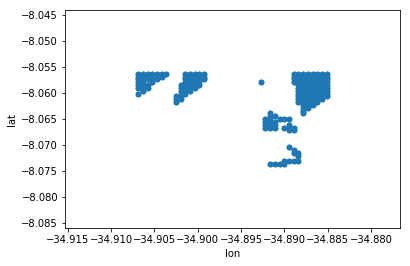

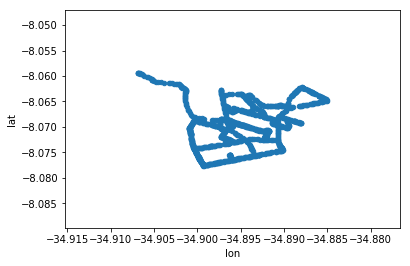

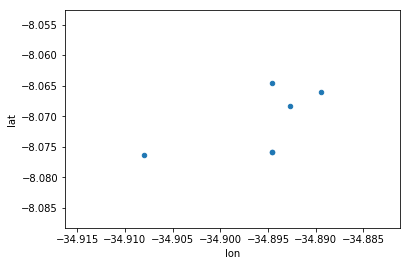

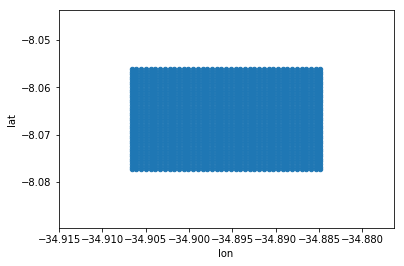

In [89]:
figure2 = df_cells.plot(kind='scatter', x='lon', y='lat')
figure2 = df_ref.plot(kind='scatter', x='lon', y='lat')
figure2 = df_antenas.plot(kind='scatter', x='lon', y='lat')
figure2 = grid.plot(kind='scatter', x='lon', y='lat')

#figure2.grid(True)

figure2

In [90]:
import folium

recife = folium.Map( location=[-8.05428, -34.8813], zoom_start=12)

In [91]:
i = 0
while i < len(df_ref):
    aux = df_ref.iloc[i]
    folium.Marker(location=[aux['lat'], aux['lon']]).add_to(recife)
    i = i+1

i = 0
while i < len(df_antenas):
    aux = df_antenas.iloc[i]
    folium.Marker(location=[aux['lat'], aux['lon']], icon=folium.Icon(color='red')).add_to(recife)
    i = i+1


i = 0
while i < len(grid):
    aux = grid.iloc[i]
    folium.Marker(location=[aux['lat'], aux['lon']], icon=folium.Icon(color='green')).add_to(recife)
    i = i+1

i = 0
while i < len(df_cells):
    aux = df_cells.iloc[i]
    folium.Marker(location=[aux['lat'], aux['lon']], icon=folium.Icon(color='pink')).add_to(recife)
    i = i+1


In [92]:
# TIRAR COMENTÁRIO PARA PLOTAR OS MAPAS COM OS PONTOS DE MEDIÇÕES,
# DO GRID REGULAR, MARCADORES DAS CÉLULAS DIVIDIDAS, E PONTOS PREDITOS

# recife

### Predição grid

In [93]:
grid.head()

,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6
0,-8.077305,-34.906603,123.873333,116.983333,124.086667,132.093333,139.893333,137.573333
1,-8.076762,-34.906603,121.806667,119.230000,118.320000,130.523333,140.266667,137.443333
2,-8.076220,-34.906603,120.716667,117.626667,112.106667,126.840000,139.066667,135.403333
3,-8.075677,-34.906603,124.410000,116.226667,117.126667,125.096667,142.456667,138.776667
4,-8.075135,-34.906603,123.448333,120.756667,120.860000,126.446667,143.538333,137.108333


In [94]:
df_ref = df_ref.dropna(axis='rows')


In [95]:
from sklearn.neighbors import KNeighborsRegressor

train_labels = grid.iloc[:, 0:2]
train_data = grid.iloc[:, 2:]

test_labels = df_ref.iloc[:, 0:2] 
test_data = df_ref.iloc[:, 2:]


In [96]:
knn_reg = KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_pred_labels = MultiOutputRegressor(knn_reg).fit(train_data, train_labels).predict(test_data)

In [97]:
y_pred = knn_pred_labels

In [98]:
y_pred

array([[ -8.07590197, -34.89639632],
       [ -8.07302738, -34.89557673],
       [ -8.07693741, -34.90239788],
       ...,
       [ -8.06610249, -34.89005299],
       [ -8.06878155, -34.89550743],
       [ -8.06482683, -34.89809488]])

### Predição novo grid

In [99]:
df_novo_grid.head()

,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6
0,-8.077305,-34.906603,123.873333,116.983333,124.086667,132.093333,139.893333,137.573333
1,-8.076762,-34.906603,121.806667,119.230000,118.320000,130.523333,140.266667,137.443333
2,-8.076220,-34.906603,120.716667,117.626667,112.106667,126.840000,139.066667,135.403333
3,-8.075677,-34.906603,124.410000,116.226667,117.126667,125.096667,142.456667,138.776667
4,-8.075135,-34.906603,123.448333,120.756667,120.860000,126.446667,143.538333,137.108333


In [100]:
train_labels1 = df_novo_grid.iloc[:, 0:2]
train_data1 = df_novo_grid.iloc[:, 2:]


# csv que vai ser lido é pra colocar no lugar de df_ref colocar df_ref2 robson
test_labels1 = df_ref.iloc[:, 0:2] 
test_data1 = df_ref.iloc[:, 2:]

In [101]:
knn_reg1 = KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_pred_labels1 = MultiOutputRegressor(knn_reg1).fit(train_data1, train_labels1).predict(test_data1)

In [102]:
y_pred1 = knn_pred_labels1

In [103]:
y_pred1

array([[ -8.07590197, -34.89639632],
       [ -8.07302738, -34.89557673],
       [ -8.07693741, -34.90239788],
       ...,
       [ -8.06615634, -34.88983356],
       [ -8.06878155, -34.89550743],
       [ -8.06482683, -34.89809488]])

### Passa para metros

In [104]:
import math

def dist_BS_MS(latB, lonB, latM,lonM):
    coord_base = (latB, lonB)
    coord_mobi = (latM, lonM)
    return geopy.distance.vincenty(coord_base, coord_mobi).m

u = 0
dists = {'dists':[]}
dists1 = {'dists1':[]}

while u<len(y_pred):
    lat1 = y_pred[u][0]
    lon1 = y_pred[u][1]
    lat2 = test_labels['lat'].iloc[u]
    lon2 = test_labels['lon'].iloc[u]
    dists['dists'].append(dist_BS_MS(lat1,lon1,lat2,lon2))
    u = u+1

u = 0
while u<len(y_pred1):
    latN1 = y_pred1[u][0]
    lonN1 = y_pred1[u][1]
    latN2 = test_labels1['lat'].iloc[u]
    lonN2 = test_labels1['lon'].iloc[u]
    dists1['dists1'].append(dist_BS_MS(latN1,lonN1,latN2,lonN2))
    u = u+1
    
df_dists = pd.DataFrame(dists)
df_distsN = pd.DataFrame(dists1)


### Erro médio, máximo, mínimo e std

In [105]:
df_dists.describe()

,dists
count,1498.000000
mean,126.442666
std,141.787269
min,2.342955
25%,43.882121
50%,79.461569
75%,155.194831
max,2140.520219


In [106]:
df_distsN.describe()

,dists1
count,1498.000000
mean,128.057591
std,142.210425
min,2.342955
25%,44.508461
50%,80.512337
75%,155.313614
max,2140.520219


### Histograma

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a26378f28>]],
      dtype=object)

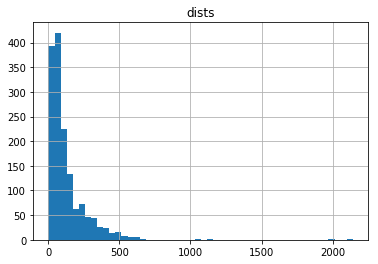

In [107]:
df_dists.hist(bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a263787f0>]],
      dtype=object)

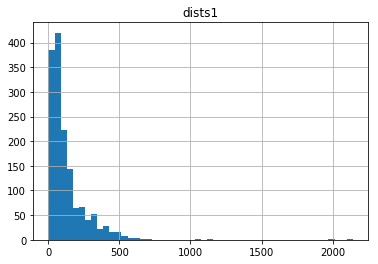

In [108]:
df_distsN.hist(bins = 50)

### BoxPlot

### Mapa de predição

In [109]:
df_pred = pd.DataFrame(y_pred1)

In [110]:
df_pred.columns = ['lat','lon']

In [111]:
df_pred.head()

,lat,lon
0,-8.075902,-34.896396
1,-8.073027,-34.895577
2,-8.076937,-34.902398
3,-8.063561,-34.889910
4,-8.067890,-34.888965


In [112]:
recife = folium.Map( location=[-8.05428, -34.8813], zoom_start=12)

In [113]:
#remove_n = 500
#drop_indices1 = np.random.choice(df_ref.index, remove_n, replace=False)
#ref_drop = df_ref.drop(drop_indices1)
#drop_indices2 = np.random.choice(df_pred.index, remove_n, replace=False)
#pred_drop = df_pred.drop(drop_indices2)

ref_drop = df_ref.iloc[1000:]
pred_drop = df_pred.iloc[1000:]




In [114]:
len(ref_drop)

498

In [115]:
i = 0

while i < len(ref_drop):
    aux1 = ref_drop.iloc[i]
    aux2 = pred_drop.iloc[i]
    folium.Marker(location=[aux1['lat'], aux1['lon']]).add_to(recife)
    folium.Marker(location=[aux2['lat'], aux2['lon']], icon=folium.Icon(color='green')).add_to(recife)
    p1 = [aux1['lat'], aux1['lon']]
    p2 = [aux2['lat'], aux2['lon']]
    folium.PolyLine(locations=[p1, p2], color='red').add_to(recife)
    i = i+1

In [116]:
# recife

In [117]:
df_distsN.head()

,dists1
0,70.573074
1,14.671843
2,298.974605
3,112.015132
4,103.206698


In [118]:
df_pred.head()

,lat,lon
0,-8.075902,-34.896396
1,-8.073027,-34.895577
2,-8.076937,-34.902398
3,-8.063561,-34.889910
4,-8.067890,-34.888965


In [119]:
df_final = pd.concat([df_pred,df_distsN], axis = 1)
df_final = df_final.rename(columns= {'lat' : 'lat_pred', 'lon': 'lon_pred', 'dists1': 'erro_loc'})
df_final.head()

,lat_pred,lon_pred,erro_loc
0,-8.075902,-34.896396,70.573074
1,-8.073027,-34.895577,14.671843
2,-8.076937,-34.902398,298.974605
3,-8.063561,-34.889910,112.015132
4,-8.067890,-34.888965,103.206698


In [120]:
paraCsv = df_ref2
paraCsv = paraCsv.drop(['pathBTS1', 'pathBTS2', 'pathBTS3', 'pathBTS4', 'pathBTS5', 'pathBTS6','taBTS1','taBTS2','taBTS3','taBTS4','taBTS5','taBTS6'], axis = 1)
paraCsv.head()

,pontoId,lat,lon
0,1578,-8.069616,-34.894836
1,1726,-8.069243,-34.888069
2,1742,-8.069219,-34.900562
3,2041,-8.068377,-34.890717
4,1970,-8.068587,-34.897018


In [121]:
df_finalCsv = pd.concat([paraCsv,df_final], axis = 1)
df_finalCsv.head()

,pontoId,lat,lon,lat_pred,lon_pred,erro_loc
0,1578.0,-8.069616,-34.894836,-8.075902,-34.896396,70.573074
1,1726.0,-8.069243,-34.888069,-8.073027,-34.895577,14.671843
2,1742.0,-8.069219,-34.900562,-8.076937,-34.902398,298.974605
3,2041.0,-8.068377,-34.890717,-8.063561,-34.889910,112.015132
4,1970.0,-8.068587,-34.897018,-8.067890,-34.888965,103.206698


In [122]:
df_finalCsv.to_csv('df_entrega.csv')